# Classifying Yelp Reviews
In this notebook, I am fitting a machine learning model to Yelp data in order to predict whether a given Yelp review is positive or negative based on its text and on other user's reactions to that review. In particular, I use Natural Language Processing (NLP) to represent each review as a vector in a feature space where each word represents its own dimension. Next, I derive a number of additional features from the text to be used as additional predictors. Finally, I train a multinomial naïve Bayes classifier on a set of labeled data and evaluate its efficacy by testing it on a separate set of data.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Data
The dataset comes from Kaggle. Each row in the dataset corresponds to a user's review of a restaurant on the Yelp app. The `stars` column corresponds to the rating that the user gave the restaurant. The `cool`, `useful`, and `funny` columns represent the different kinds of "likes" that the review, itself, received from other users on the app.

In [2]:
yelp = pd.read_csv('yelp.csv')
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


To turn this into a binary classification problem, I'm going to only consider the reviews where users were either very satisfied (5 stars) or very unsatisfied (1 star).

In [3]:
yelp = yelp[(yelp.stars == 1) | (yelp.stars == 5)]

In [4]:
yelp.index = np.arange(0,4086)

## Feature Engineering
It would be nice to derive some more variables from the existing ones in the dataset. We're going to do so with the vectorization of the text, but even before then, there are a few improvements we can make.

In particular, we can pull out a word count. Maybe longer reviews tend to be more negative (or vice-versa).

In [5]:
yelp['text_length'] = yelp['text'].apply(lambda x: len(x.split()))

We can also use the `date` column to create a feature that describes whether or not a given review was written on a weekend. (Friday and Saturday are the busiest restaurant days, so that's what we'll consider to be the weekend.)

In [6]:
def weekend_or_weekday(row):
    wkday = datetime.strptime(row.date, "%Y-%m-%d").weekday()
    return "weekend" if (wkday == 4) else "weekday"

In [7]:
yelp["weekend"] = yelp.apply(weekend_or_weekday, axis=1)

I'd like to create a variable to track the overall responses to a review, regardless of what that response was. I might not use this later, but it could be helpful to track.

In [8]:
yelp['likes'] = yelp.cool + yelp.useful + yelp.funny

Lastly, I think we can pull out another characteristic of the review, itself. I think number of exclamation points would be an interesting one. I'll normalize by the length of the review.

In [9]:
yelp["excitement"] = yelp.apply(lambda x: (len(x.text.split("!")) - 1) / x.text_length, axis=1)

In [10]:
yelp[yelp["excitement"] == max(yelp["excitement"])].text.values

array(['Best pizza place ever!!!!!!!!!!!!!!'], dtype=object)

Ha.

## Exploratory Data Analysis
Before diving in with the modeling, I want to make sure that this dataset is amenable to machine learning techniques, explore possible opportunities for feature engineering, and get a better general understanding of its nuances.

Let's take a look at some of these reviews.

In [11]:
print(yelp.text[905] + "\n\n\n" + yelp.text[200] + "\n\n\n" + yelp.text[51])

Championship establishment here.

I walked in with my significant other and was surprised at how busy it was on a Tuesday night. At first, it didn't click but the entire volleyball team from a nearby high school decided to come so it was extremely busy.

They have some really good specials, but what really caught my eye was the specialty burgers that are $6. Big misunderstanding, most $6 are single patty and have some special toppings. Zipps decided to do a double-stacked specialtly burger. Yes, two 1/3 lb patties on a bun with some special toppings. We got two burgers and split them half and half, green chile burger and sweet jalapeno. Both were extremely awesome. You can get salad, fries, onion rings or half-half (half fries half onion rings). The fries kind of taste like In-n-Out fries, and my significant other would describe them as being better. I don't agree, and I don't disagree. Overall, good food, I can't wait to come back and try something else from their special menu. The $6

I'm remembering now that not all of these reviews are for restaurants, so the `weekend` feature I came up with earlier might not be terribly helpful.

An important consideration for many models is how *balanced* the dataset is. There need to be sufficient positive and negative samples (high and low star reviews) to establish enough contrast for the model to distinguish between them. Let's check the distribution of reviews by star rating.

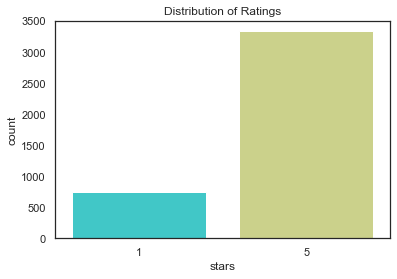

In [12]:
sns.set_theme(style="white")
star_dist_ax = sns.countplot(data=yelp, x='stars', palette='rainbow')
star_dist_ax.set_title("Distribution of Ratings");

In [13]:
print(str(round(yelp.stars.value_counts(normalize=True).values[0]*100, 1)) + "% of the reviews in our dataset are 5 stars.")

81.7% of the reviews in our dataset are 5 stars.


There appears to be a decent amount (700+ rows) of data on either end, though there are far more positive reviews than negative. As a result, we can expect our model to be biased towards predicting that any given review is positive. 

In fact, a model that classified every single review as a 5 star review would be 81.7% accurate, so that is the number to beat. This also means that classification accuracy is probably not a good performance measure. Instead, I'll be keeping an eye on the recall and precision scores for the 1 star category as well as the weighted f1 score averages.

There are a few options to correct the inbalance in the dataset. Oversampling from the 1 star category is a good option since the dataset is not sufficiently large to undersample from the 5 star category. I can also penalize the model more for misclassifying negative reviews.

One assumption of the multinomial naïve Bayes model is that the variables are all independent from one another. This is a strong assumption (and is actually where the "naïve" comes from) because variable independence is uncommon in practice. However, this type of model has proven to be effective even with some correlation between variables. Let's see how badly we might be violating that assumption.

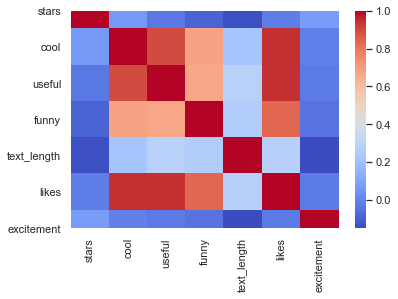

In [14]:
hmap = sns.heatmap(data=yelp.corr(), cmap="coolwarm");

It appears that the different kinds of likes correlate with one another, which makes sense because highly rated reviews might get seen (and voted on) by more people. They also correlate with the consolidated `likes` feature as this is just their sum. 

## Count Vectorization
In this step, I'll turn each review into a vector whose separate components represent each word used in the overall text corpus (all the reviews, together). This is known as the Bag-of-Words technique.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
cv = CountVectorizer()

In [17]:
vectorized_counts = cv.fit_transform(yelp["text"])

In [18]:
X = pd.DataFrame(vectorized_counts.toarray())

In [19]:
X["text_length"] = yelp.text_length
X["likes"] = yelp.likes
X["excitement"] = yelp.excitement

## Train, Predict, and Evaluate
Here, I will split the data into training and testing sets, train the naive bayes classifier on the training set, and evaluate it using the withheld testing set.

#### Split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, yelp.stars, test_size=0.2, random_state=99)

#### Train

In [23]:
from sklearn.naive_bayes import MultinomialNB

In [24]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

#### Predict

In [25]:
prd = nb_model.predict(X_test)

#### Evaluate

In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(y_test, prd))

              precision    recall  f1-score   support

           1       0.81      0.72      0.76       141
           5       0.94      0.96      0.95       677

    accuracy                           0.92       818
   macro avg       0.88      0.84      0.86       818
weighted avg       0.92      0.92      0.92       818



Okay, so the classifier was able to distinguish between 5 star and 1 star reviews to 92% accuracy.

This definitely beats the 81.7% goal we had set. I'll be coming back through soon to try and improve that margin. I'd like to account for the imbalanced data as well as to try a few other models. I'd also like to account for the frequency of different words since I have not removed stopwords.